# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?

# FLUJO DE TRABAJO

# 1 - Obtencion de datos

In [1]:
#descargamos las librerias que vamos a usar y las configuraciones
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize

#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dataset = pd.read_json(r'C:\Users\Luigi\Documents\02.Proj_Amazon-NLP\dataset_es_dev.json',lines=True)

# 2 - Exploracion de datos

In [3]:
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


<AxesSubplot:xlabel='count', ylabel='product_category'>

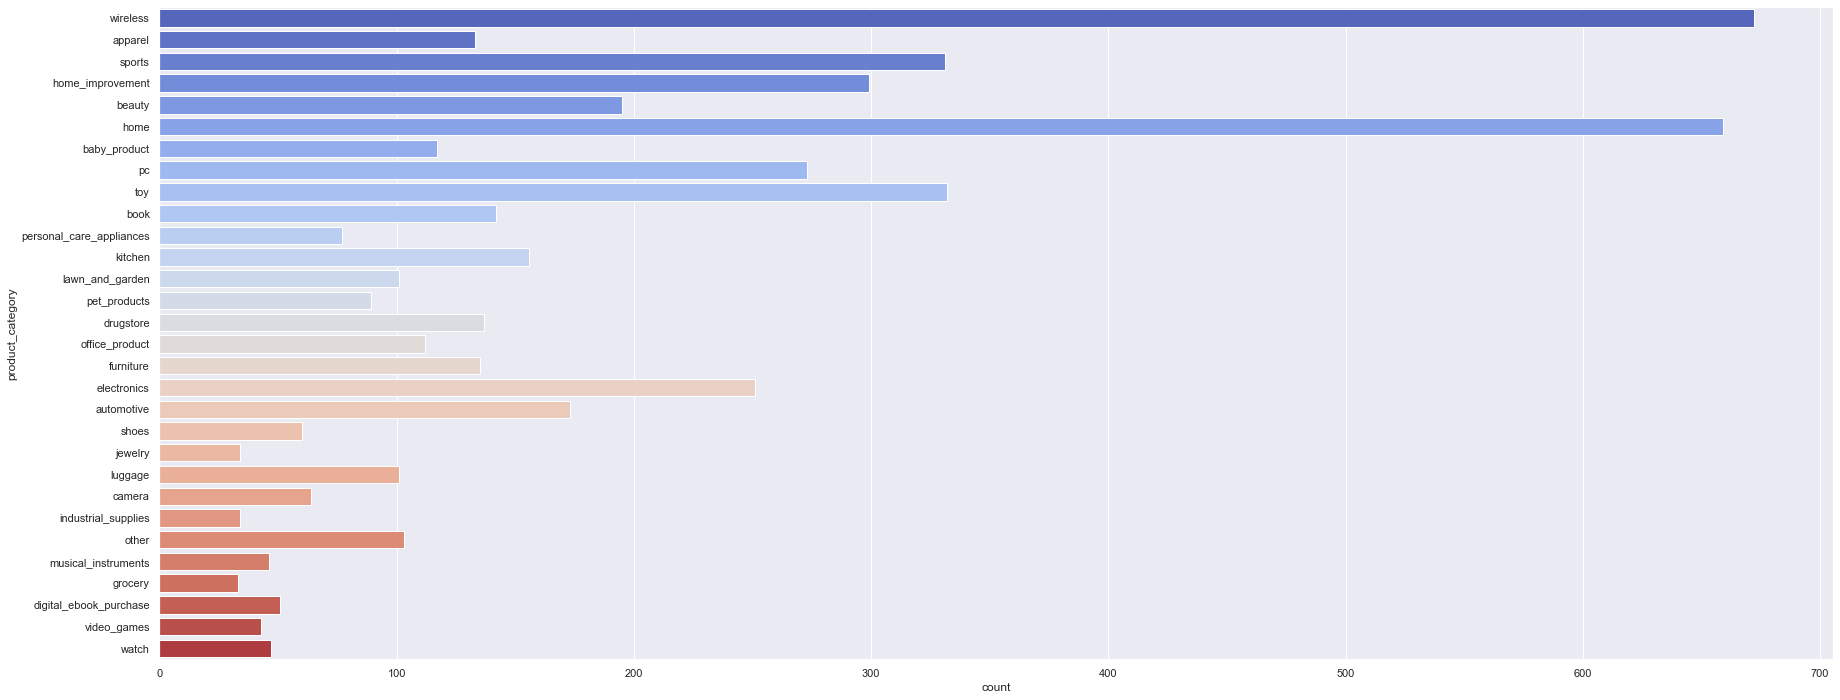

In [4]:
plt.figure(figsize=(30,12))
sns.countplot(data = dataset, y = "product_category", palette="coolwarm")

In [5]:
dataset.shape

(5000, 8)

In [6]:
dataset.dtypes

review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object

In [7]:
dataset.count()

review_id           5000
product_id          5000
reviewer_id         5000
stars               5000
review_body         5000
review_title        5000
language            5000
product_category    5000
dtype: int64

Con esto nos damos cuenta de que los datos tienen 8 columnas y 5000 filas. Ademas, por el nombre de las cabeceras nos damos cuenta que muy posiblemente este dataset este estructurado mediante SQL. Vemos que hay tres IDs asociados: uno correspondiente a la review, otro relacionado al producto y otro a la critica. Tambien podemos ver que en esta tabla nos indica el lenguaje (importante para ver que tipos de librerias usamos) y ademas vemmos que los productos tienen una categoria asociada. Por ultimo vemos la cantidad de estrellas que se dio a ese producto dada la review.

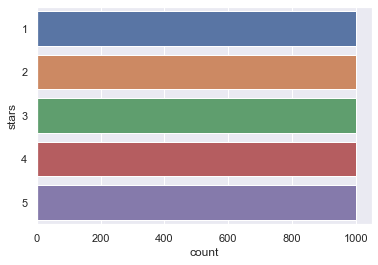

In [8]:
sns.countplot(data = dataset , y='stars')
plt.show()

Con esto vemos que de un total de 5000 registros, estos tienen una distribucion equiprobable segun su clasificacion. Ahora veamos un comentario random del dataset y como expresan los usuarios sus gustos..

In [9]:
index_random = np.random.randint(1,4000)
titular = dataset.review_body.iloc[index_random]
print(index_random, titular)
print(index_random, dataset.stars.iloc[index_random])

3749 Es lo que esperaba,el pedido vino a tiempo
3749 4


A continuacion vemos algunos registros y como estos tienen asociado el titulo del review

In [10]:
dataset2 = dataset.iloc[:,[4,5,3]]
#dataset2.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset2.head()

,review_body,review_title,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,1
1,No he recibido el pedido no la devolución,No lo he recibido,1
2,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,1
3,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,1
4,No me gusta su olor a viejo y aspecto malo,No me gusta,1


In [11]:
data_concat = dataset2.review_title + " " +dataset2.review_body
data_concat
dataset["Todojunto"] = data_concat
dataset

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,Todojunto
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,"Mala compra Malisimo, muy grande demasiado apa..."
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,No lo he recibido No he recibido el pedido no ...
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,Que no aprieta bien en el manillar Tengo que b...
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,Brocas de mantequilla Utilicé las brocas de me...
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,No me gusta No me gusta su olor a viejo y aspe...
...,...,...,...,...,...,...,...,...,...
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,guadalupe Me ha encantado la cesta. Ha llegado...
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera,calidad precio Desempeña su función correctamente
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,Excelente Me ha encantado la diadema! Las flor...
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,"Genial A mi me gustan mucho las fundas TPU, ya..."


# 3 - Normalizacion

En esta etapa limpiaremos los caracteres, tokenizaremos y llevaremos a raiz las palabras del dataset mediante la stematizacion o lemmatizacion.

Comenzaremos desasiendonos de las palabras que tienen menos carga semantica para trabajar con los que tienen mayor ponderacion. Para ello traeremos el catalogo predefinido como stopword de la libreria NLTK

In [12]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
#stopwords
print(stopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

## 3.1 - Stemmer

In [13]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import SnowballStemmer
# spanish_stemmer = SnowballStemmer('spanish')
# (spanish_stemmer.stem("texto_en_str"))
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()


In [14]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list=[]
simb=["!",".",",","no","si","...",")","("]
todaslaspalabras=[]
for review in dataset.Todojunto:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    #review=re.sub(","," ",str(review))#borra los espacios y las tiles
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)
    # Eliminamos las palabras de menos de 3 letras
    #dataset = [palabra for palabra in dataset if len(palabra)>2]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords if not palabra in simb]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[stemmer.stem(palabra) for palabra in review]

    todaslaspalabras.append(review)
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    
    # Vamos armando una lista con todos los titulares
    review_list.append(review)
    #dataset["titular_normalizado"] = titular_list

In [15]:
flat_list = [item for t in todaslaspalabras for item in t]
flat_list[0:30]

['mala',
 'compra',
 'malisimo',
 'grand',
 'demasiado',
 'aparatoso',
 'mal',
 'protector',
 'pantalla',
 'recibido',
 'recibido',
 'pedido',
 'devolución',
 'aprieta',
 'bien',
 'manillar',
 'buscar',
 'sistema',
 'funciona',
 'bien',
 'abrazadera',
 'lleva',
 'agarrar',
 'manillar',
 'aprieta',
 'bien',
 'deslizando',
 'linterna',
 'hacia',
 'abajo']

In [16]:
review_list[0:10] #Porque tengo que correr todo de nuevo??????

['mala compra malisimo grand demasiado aparatoso mal protector pantalla',
 'recibido recibido pedido devolución',
 'aprieta bien manillar buscar sistema funciona bien abrazadera lleva agarrar manillar aprieta bien deslizando linterna hacia abajo',
 'broca mantequilla utilicé broca menor diámetro doblaron varia mantequilla hacer mínima presión vez doblada intentar enderezarla parten exteriorment amarilla interior fundido gri peor compra hecho bastant tiempo',
 'gusta gusta olor viejo aspecto malo',
 'bola rota hola despué recog paquet llegado bola rota',
 'part poder elegir color part poder elegir color envian cesto color asa imagino aprovechando van rompiendo dicen color aleatorio foto cesta asa mismo color recomiendo comprarlo pueda elegir color único alivio romperá pronto calidad allá',
 'tapa pantalla baja calidad ahí precio compra supon tirar dinero',
 'recibido producto producto sale entregado recibido',
 'patata recomiendo pega acaba despegandos']

In [17]:
freq = nltk.FreqDist(flat_list)
freq

FreqDist({'bien': 1632, 'calidad': 1102, 'producto': 833, 'buena': 754, 'precio': 721, 'buen': 460, 'funciona': 364, 'bastant': 360, 'perfecto': 336, 'mejor': 314, ...})

In [18]:
dataset["review_stem"] = review_list
dataset.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,Todojunto,review_stem
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,guadalupe Me ha encantado la cesta. Ha llegado...,guadalup encantado cesta llegado impecable.tie...
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera,calidad precio Desempeña su función correctamente,calidad precio desempeña función correctament
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,Excelente Me ha encantado la diadema! Las flor...,excelent encantado diadema flore tal vienen im...
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,"Genial A mi me gustan mucho las fundas TPU, ya...",genial gustan funda tpu funda normalment fina ...
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel,Buena calidad El artículo ha cumplido con las ...,buena calidad artículo cumplido expectativa de...


In [19]:
#print(review_list)

In [20]:
df_freq = pd.DataFrame(list(freq.items()), columns = ["Word", "frecuency"])
df_freq.sort_values('frecuency',ascending=False, inplace = True)
df_freq.head(10)

,Word,frecuency
13,bien,1632
84,calidad,1102
93,producto,833
596,buena,754
89,precio,721
1277,buen,460
17,funciona,364
47,bastant,360
1627,perfecto,336
517,mejor,314


In [21]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [22]:
import re, string

def remove_punctuation ( flat_list ):
  return re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

df_freq = pd.DataFrame(list(freq.items()), columns = ["Word", "Frecuency"])
df_freq.sort_values('Frecuency',ascending=False, inplace = True)
df_freq.head()

,Word,Frecuency
13,bien,1632
84,calidad,1102
93,producto,833
596,buena,754
89,precio,721


In [23]:
Good = list(itertools.chain(*freq))
Good[0:10]

['b', 'i', 'e', 'n', 'c', 'a', 'l', 'i', 'd', 'a']

In [24]:
print(nltk.word_tokenize(review))

['buena', 'calidad', 'artículo', 'cumplido', 'expectativa', 'deseaba']


Falta distribucion de frecuencia de palabras con seaborn.
Ver la frecuencia de palabras ahora segmentado por rubro

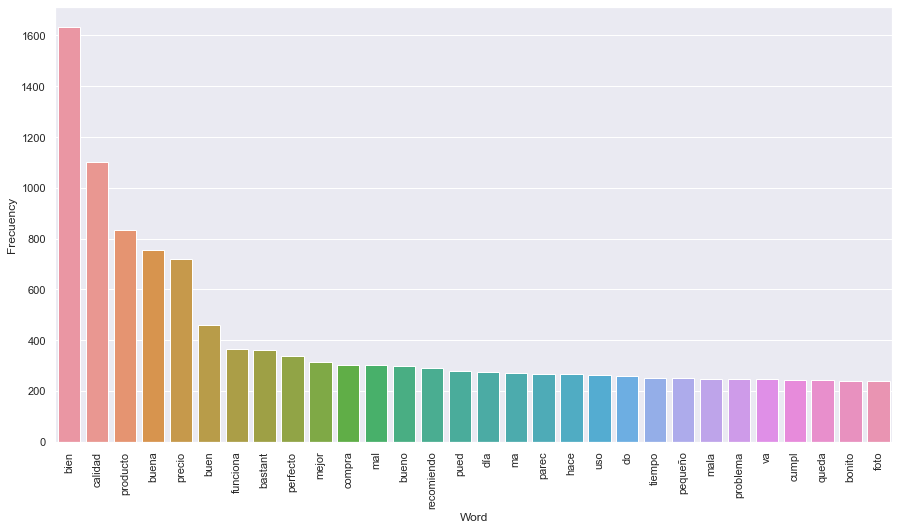

In [25]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_freq.iloc[:30].Word, y = df_freq.iloc[:30].Frecuency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

# 4 - Vectorizacion

In [26]:
dataset["review_stem"] = review_list
dataset.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,Todojunto,review_stem
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,guadalupe Me ha encantado la cesta. Ha llegado...,guadalup encantado cesta llegado impecable.tie...
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera,calidad precio Desempeña su función correctamente,calidad precio desempeña función correctament
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,Excelente Me ha encantado la diadema! Las flor...,excelent encantado diadema flore tal vienen im...
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,"Genial A mi me gustan mucho las fundas TPU, ya...",genial gustan funda tpu funda normalment fina ...
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel,Buena calidad El artículo ha cumplido con las ...,buena calidad artículo cumplido expectativa de...


In [27]:
dataset.tail()
list_review_stem = list(dataset['review_stem'].values)
Calification = dataset['stars'].values

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=10000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

In [29]:
matriz_reviews = cou_vec.fit_transform(list_review_stem)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['10', '100', '1000', '100x100', '1080', '10cm', '10mm', '11', '12', '125', '12m', '12v', '12º', '13', '130', '135', '14', '15', '150', '150w', '150x190', '15h', '15min', '16', '160', '16gb', '17', '18', '180', '180gr', '18kg', '18º', '19', '1978', '1a', '1er', '1h', '1º', '20', '200', '2000', '20000', '2001', '2006', '2007', '200w', '2011', '2017', '2018', '2019']


# 5 - Modelado

In [30]:
x = matriz_reviews.toarray()
y = Calification

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [31]:
matriz_reviews.shape

(5000, 10000)

In [32]:
len(Calification)

5000

In [33]:
len(ytrain)

4000

# Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 200, random_state=42, max_depth=5)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.419


In [35]:
print("acc: ",rf.score(xtrain,ytrain))

acc:  0.56975


In [36]:
xtrain.shape

(4000, 10000)

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

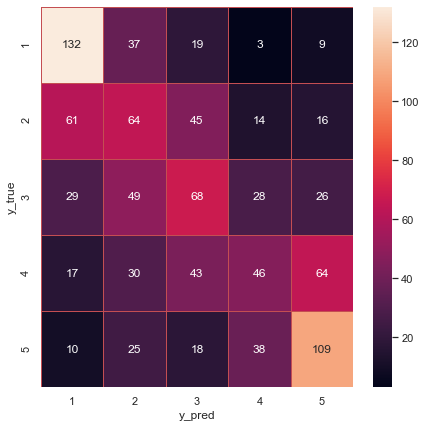

In [38]:
y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

## Utilizamos rf porque nb de gauss arrobaja peores resultados. El modelo hace mejor match con las bajas calificaciones que con las altas. Sesgo positivo en general. Problema para analizar las calificaciones positivas.


C:\Users\Luigi\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
C:\Users\Luigi\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
C:\Users\Luigi\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
C:\Users\Luigi\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed

Text(0, 0.5, 'Probability Density')

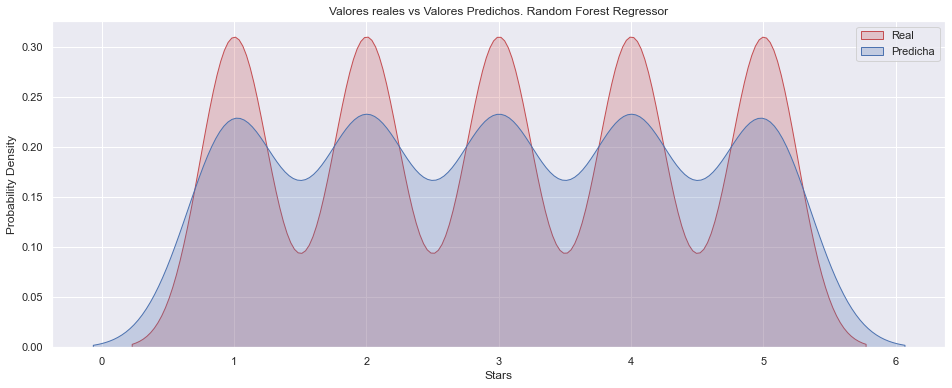

In [39]:
plt.figure(figsize = (16,6))
sns.kdeplot(y, color='r', shade=True, Label='Real')
  
sns.kdeplot(ytest, color='b', shade=True, Label='Predicha')


plt.legend()  
plt.title("Valores reales vs Valores Predichos. Random Forest Regressor")
plt.xlabel('Stars')
plt.ylabel('Probability Density')

# Random Forest Reggresor

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import sklearn.metrics as metrics


In [41]:
clf_tree = RandomForestRegressor(n_estimators=1500, max_features=5000,n_jobs=-1, random_state = 0)
clf_tree.fit(xtrain,ytrain)


RandomForestRegressor(max_features=5000, n_estimators=1500, n_jobs=-1,
                      random_state=0)

In [42]:
y_train_pred_clf = clf_tree.predict(xtrain)
y_test_pred_clf = clf_tree.predict(xtest)


In [43]:
print('RMSE para Train', np.sqrt(metrics.mean_squared_error(ytrain, y_train_pred_clf)))
print('RMSE para Test', np.sqrt(metrics.mean_squared_error(ytest, y_test_pred_clf)))


RMSE para Train 0.40746564217803144
RMSE para Test 1.1273681683953611


In [44]:
comparacion_tree_reg = pd.DataFrame({'Real Values':ytest, 'Predicted Values':y_test_pred_clf})
comparacion_tree_reg


,Real Values,Predicted Values
0,2,1.313333
1,4,3.526000
2,1,1.727333
3,3,3.439333
4,3,2.900000
...,...,...
995,2,4.225333
996,1,3.706667
997,1,1.646667
998,3,1.485333
